In [7]:
import os
import numpy as np
import art
import torchvision
from torchvision import transforms as transforms
from PIL import Image
import torch
import torchvision.models as models
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pycocotools.coco import COCO
import random
import cv2
import pycocotools.coco as coco

np.random.seed(43)

In [8]:
annFile='annotations\instances_val2017.json'
coco=COCO(annFile)
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]

nms = set([cat['supercategory'] for cat in cats])

catIds = coco.getCatIds(catNms=['giraffe','zebra','elephant']);
imgIds=[]
for i in catIds:
    imgIds.append(coco.getImgIds(catIds=i ))
imgIds = [item for sublist in imgIds for item in sublist]
np.random.shuffle(imgIds)
randImgIds = imgIds[:10]

#coco.download(tarDir = "photos", imgIds = randImgIds)

loading annotations into memory...
Done (t=0.58s)
creating index...
index created!


In [38]:
def draw_image_with_boxes(image_as_array):
    predictions = art_model.predict(np.float32(image_as_array))
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(predictions[0]['labels'])]
    boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(predictions[0]['boxes'])] # Bounding boxes
    pred_score = list(predictions[0]['scores'])
    img = np.resize(image_as_array, image_as_array.shape[1:])
    for i in range(len(boxes)):
        if pred_score[i] > 0.4:
            cv2.rectangle(img, boxes[i][0], boxes[i][1],color= (255,0,0), thickness=2) # Draw rectangle
            cv2.putText(img,pred_class[i] + ", "+ str(round(pred_score[i],2)), boxes[i][0],  cv2.FONT_HERSHEY_PLAIN, 2, (255,0,0),thickness=2) # Write the prediction class and score     
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
def load_image_from_path(img_path):
    image = Image.open(img_path).convert('RGB')
    image_as_array = np.array(image)
    image_as_array = np.expand_dims(image_as_array, 0)
    return image_as_array
    
def make_images_array(dictionary, width,height):
    images_paths = [f for f in os.listdir(dictionary) if os.path.isfile(os.path.join(dictionary, f))]
    #(n,width,height,3)
    images_array = np.empty([len(images_paths),width,height,3])
    
    for i, image_path in enumerate(images_paths):
        image = Image.open(dictionary +"/" + image_path).convert('RGB')
        image = image.resize((width,height))
        img_arr = np.array(image)
        images_array[i,:,:,:] = np.array(image)
    return images_array

Loading models, both of them are pretrained on COCO dataset <br />
Here is link to model documentation: https://pytorch.org/vision/stable/models.html#faster-r-cnn

In [10]:
art_model = art.estimators.object_detection.PyTorchFasterRCNN(clip_values=[0,255])

Let's read a real image and get them to our model

In [11]:
image = Image.open("giraffe.jpg").convert('RGB')

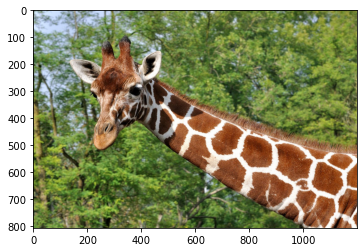

In [12]:
imgplot = plt.imshow(image)
plt.show()

In [13]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

We can put an np.array image directly to our model and get appropriate output

Now we can add predicted boxes to our picture <br/>
Pictures seems to be slightly too big

(1, 683, 1024, 3)
[{'boxes': array([[563.2966 , 345.4033 , 880.6374 , 596.13367],
       [187.74016, 220.00261, 500.19757, 578.8625 ],
       [464.5193 , 448.03387, 589.05597, 567.2614 ]], dtype=float32), 'labels': array([22, 22, 22], dtype=int64), 'scores': array([0.999671  , 0.99941766, 0.9988954 ], dtype=float32)}]


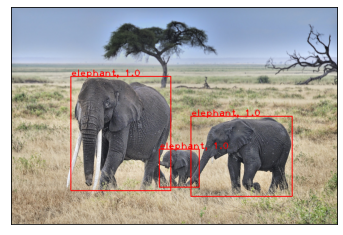

In [14]:
array = load_image_from_path("elephant.jpg")
print(array.shape)
draw_image_with_boxes(array)

In [15]:
attackDPatch = art.attacks.evasion.DPatch(art_model, batch_size = 1, max_iter = 500)
attackRobustDPatch = art.attacks.evasion.RobustDPatch(art_model, batch_size = 1, max_iter = 5000)

In [16]:
images_array = make_images_array("photos", 224, 224)
print(images_array.shape)

(11, 224, 224, 3)


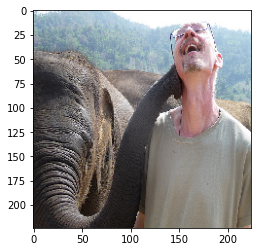

In [17]:
image = Image.fromarray(np.uint8(images_array[0,:,:,:]))
plt.imshow(image)
plt.show()

In [21]:
print(attackDPatch)
print(attackRobustDPatch)

(224, 224, 3)


Now we can conduct attact

In [23]:
adv_patch_robust = attackRobustDPatch.generate(np.float32(images_array[0:1,:,:,:]))

RobustDPatch iteration:   0%|          | 0/5000 [00:00<?, ?it/s]

In [31]:
mask = (np.zeros(images_array.shape[1:-1]) == 0)
mask = np.expand_dims(mask, 0)
torch.cuda.empty_cache()

In [30]:
adv_patch_dpatch = attackDPatch.generate(np.float32(images_array), mask = mask)

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 6.00 GiB total capacity; 3.84 GiB already allocated; 17.81 MiB free; 4.15 GiB reserved in total by PyTorch)

In [41]:
print(adv_patch_robust.shape)

(40, 40, 3)


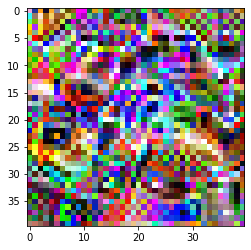

In [47]:
patch_img = Image.fromarray((adv_patch_robust).astype(np.uint8))
patch_img.save("RobustDPatch5000.jpg")
plt.imshow(patch_img)
plt.show()

In [22]:
adv_patch_robust = load_image_from_path("RobustDPatch2.jpg")
adv_patch_robust.resize((40,40,3))

In [26]:
pathed_image = attackRobustDPatch.apply_patch(np.float32(images_array),patch_external = adv_patch_robust)

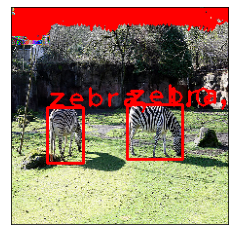

In [39]:
torch.cuda.empty_cache()
image = pathed_image[1,:,:,:].astype(int)
image = np.expand_dims(image, 0)
draw_image_with_boxes(image)

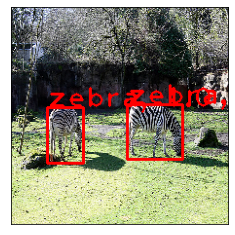

In [40]:
normal_images = images_array[1,:,:,:].astype(int)
normal_images = np.expand_dims(normal_images, 0)
#print(image)
draw_image_with_boxes(normal_images)

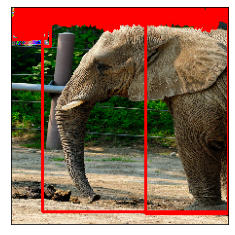

In [44]:
torch.cuda.empty_cache()
image = pathed_image[3,:,:,:].astype(int)
image = np.expand_dims(image, 0)
draw_image_with_boxes(image)

In [46]:
normal_images = images_array[3,:,:,:].astype(int)
normal_images = np.expand_dims(normal_images, 0)
#print(image)
draw_image_with_boxes(normal_images)

RuntimeError: CUDA out of memory. Tried to allocate 40.00 MiB (GPU 0; 6.00 GiB total capacity; 3.90 GiB already allocated; 7.81 MiB free; 4.16 GiB reserved in total by PyTorch)

In [45]:
attact_predictions = art_model.predict(np.float32(pathed_image))
normal_predictions = art_model.predict(np.float32(normal_images))

RuntimeError: CUDA out of memory. Tried to allocate 108.00 MiB (GPU 0; 6.00 GiB total capacity; 3.81 GiB already allocated; 47.81 MiB free; 4.12 GiB reserved in total by PyTorch)